# **Auto Regressive eXogenous Input (ARX) Model**

In [1]:
# Essential packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Statsmodels packages
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf
#import statsmodels.api as sm

# Scikit-learn packages
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Warning Supression
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load data
u_train = np.load("./data/u_train.npy")
u_test = np.load("./data/u_test.npy")
y_train = np.load("./data/output_train.npy")

## **Check Data Format**

In [ ]:
df = pd.DataFrame(u_train, columns=['U'])
df['Y'] = y_train

pd.set_option('display.max_rows', None)
print(df)

## Data Analysis

In [ ]:
def CorrelationPlots(y_train, u_train):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot ACF
    plot_acf(y_train, lags=10, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF) of the output")
    axes[0].set_xlim([-0.5, 10.5])
    axes[0].set_ylim([-1, 1.2])

    # Plot PACF
    plot_pacf(y_train, lags=10, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF) of the output")
    axes[1].set_xlim([-0.5, 10.5])
    axes[1].set_ylim([-1, 1.2])

    # Plot PACF
    plot_ccf(x=u_train, y=y_train, lags=range(0,20), ax=axes[2])
    axes[2].set_title("Cross Correlation Function (CCF) of the output with input")
    axes[2].set_xlim([5.5, 16.5])
    axes[2].set_ylim([-0.25, 0.25])

    plt.tight_layout()
    plt.show()

# Visualization of the ARX matrix parameters
CorrelationPlots(y_train, u_train)

## **Construction of the regression matrix X and output vector Y**

In [2]:
def BuildArxMatrix(y_train, u_train, n, m, d):
    """
    Constructs the regression matrix X and output vector Y for an ARX model.
    """
    # Calculate the starting index based on the number of lags and delay
    p = max(n, d + m)

    X = []
    y = []

    for k in range(p, len(y_train)):
        # Create the regressor vector for the current time step k
        regressor_vector = []

        # Include past n outputs y(k-1), y(k-2), ..., y(k-n) 
        # and past m+1 lagged inputs u(k-d), u(k-d-1), ..., u(k-d-m)
        regressor_vector = [y_train[k - i] for i in range(1, n + 1)] + \
                           [u_train[k - d - j] for j in range(m + 1)]
        
        # Append the regressor vector to X
        X.append(regressor_vector)

        # Append the current output y(k) to Y
        y.append(y_train[k])

    X = np.array(X)
    y = np.array(y)

    return X, y

def IterativePrediction(y_past, u_input, mu, sigma, n, m, d, model):
    """
    Predict y(k) with previous ones. u_input is bigger than y_past and contains future inputs (in time).
    """
    index_y = len(y_past)
    index_diff = len(u_input) - len(y_past)

    y_full = np.array(y_past) # Copy past index values of y

    for k in range(index_diff):
        regressor_vector = [y_full[index_y + k - i] for i in range(1, n + 1)] + \
                           [u_input[index_y + k - d - j] for j in range(m + 1)]

        regressor_vector = (regressor_vector - mu) / sigma

        # print(f"k={k},\n {np.array(regressor_vector)}\n")

        y_pred = model.predict(np.array(regressor_vector).reshape(1, -1))
        y_full = np.append(y_full, y_pred[0])

    return y_full, y_full[len(y_past):]

#X, _ = BuildArxMatrix(y_train, u_train, 0, 2, 0)
#print(X)
#print(len(X))

## **Selection of optimal values for `m`, `n` and `d`**

In [ ]:
def AIC(y_true, y_pred, n, m):
    SSE = np.sum((y_true - y_pred) ** 2)
    
    # Assuming Gaussian errors, log-likelihood calculation
    n = len(y_pred)
    sigma_squared = SSE / n
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma_squared) + 1)

    # Calculate AIC
    k = n + m + 1
    aic = 2 * k - 2 * log_likelihood

    # Calculate AICc (corrected AIC for small sample sizes)
    if n - k - 1 > 0:
        aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
    else:
        # To avoid division by zero or negative values in small sample cases, fall back to AIC
        aicc = aic

    return aicc

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

def CheckStability(a_coeffs):
    # Coefficients for the characteristic polynomial: P(z) = z^n + a1*z^(n-1) + ... + an
    poly_coeffs = np.concatenate(([1.0], -a_coeffs))
    roots = np.roots(poly_coeffs)
    #print(f"Coeff: {poly_coeffs.flatten()}")
    #print(f"Roots: {roots.flatten()}")
    return roots, np.all(np.abs(roots) < 1)

def TwoStageGridSearch(y, u, n_values, m_values, d_values, param_grid, n_splits=5):
    best_score = float('inf')
    best_sse = float('inf')
    best_aic = float('inf')
    best_model = None
    best_params = None
    best_matrix = None
    best_mu = None
    best_sigma = None

    # Outer loop: iterate through all combinations of n, m, and d
    for n in n_values:
        for m in m_values:
            for d in d_values:
                # Build ARX matrix using full data
                X_arx_full, y_arx_full = BuildArxMatrix(y, u, n, m, d)

                # Split data into training and validation
                split_index = int(1.00 * len(y_arx_full))
                X_train, X_val = X_arx_full[:split_index], X_arx_full[split_index:]
                y_train, y_val = y_arx_full[:split_index], y_arx_full[split_index:]

                # Standardize training data
                mu = np.mean(X_arx_full, axis=0)
                sigma = np.std(X_arx_full, axis=0)
                X_train_std = (X_train - mu) / sigma

                #print(X_train.shape)
                #print(f"Mu: {mu.flatten()}")
                #print(f"Sigma: {sigma.flatten()}")

                # Set up cross-validation
                tscv = BlockingTimeSeriesSplit(n_splits=n_splits)

                """
                # Print splits for debugging
                for fold, (train_indices, test_indices) in enumerate(tscv.split(X_train_std), 1):
                  print(f"Fold {fold}")
                  print(f"Train indices: {train_indices}")
                  print(f"Test indices: {test_indices}")
                  print(f"Number of training samples: {len(train_indices)}")
                  print(f"Number of test samples: {len(test_indices)}\n")
                """

                # Set up regression and parameter grid
                model = Lasso(max_iter=5000)

                # Set up scorer
                aicc_score = make_scorer(ScorerAIC, greater_is_better=True, n=n, m=m)
                
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=param_grid,
                    scoring={
                        'neg_mean_squared_error': 'neg_mean_squared_error',
                        'r2': 'r2'
                    },
                    refit='neg_mean_squared_error',
                    cv=tscv,
                    verbose=0
                )

                # Fit GridSearchCV to training data
                grid_search.fit(X_train_std, y_train)
                best_inner_model = grid_search.best_estimator_
                best_inner_params = grid_search.best_params_
                best_inner_score = grid_search.best_score_
                best_index = grid_search.best_index_

                mean_rmse = np.sqrt(-grid_search.cv_results_['mean_test_neg_mean_squared_error'][best_index])
                std_rmse = np.sqrt(grid_search.cv_results_['std_test_neg_mean_squared_error'][best_index])
                mean_r2 = grid_search.cv_results_['mean_test_r2'][best_index]
                std_r2 = grid_search.cv_results_['std_test_r2'][best_index]

                cv_rmse = {'mean RMSE': mean_rmse, 'stddev': std_rmse}
                cv_r2 = {'mean R2': mean_r2, 'stddev': std_r2}
                
                # Check stability
                destandardized_coeffs = best_inner_model.coef_ / sigma
                roots, is_stable = CheckStability(destandardized_coeffs[:n])
                
                if not is_stable:
                        print(f"Model with n={n}, m={m}, d={d} is unstable. Skipping.")
                        print(f"Roots: {roots}")
                        continue  # Skip this model if unstable
                
                # Only perform validation if there is a validation set
                if split_index != len(y_arx_full):
                    # Validate on the validation set
                    
                    y_full, y_pred_val = IterativePrediction(y_train, u[max(n, d + m):], mu, sigma, n, m, d, best_inner_model)
                    sse_val = np.sum((y_pred_val - y_val) ** 2)
                    mae_val = np.sum(np.abs(y_pred_val - y_val))
                    r2_val = r2_score(y_pred_val, y_val)
                    aic_val = AIC(y_val, y_pred_val, n, m)
                    
                    # Update the best model if current SSE is lower
                    if aic_val < best_aic:
                        best_matrix = {'n': n, 'm': m, 'd': d}
                        best_model = best_inner_model
                        best_params = grid_search.best_params_
                        best_cv_rmse = cv_rmse
                        best_cv_r2 = cv_r2
                        best_aic = aic_val
                        best_sse = sse_val
                        best_mae = mae_val
                        best_r2 = r2_val
                        best_mu = mu
                        best_sigma = sigma
                        best_y_pred = y_pred_val

                # Otherwise, evaluate with the CV score
                else:
                    score = -best_inner_score
                    if score < best_score:
                        best_matrix = {'n': n, 'm': m, 'd': d}
                        best_model = best_inner_model
                        best_params = grid_search.best_params_
                        best_cv_rmse = cv_rmse
                        best_cv_r2 = cv_r2
                        best_score = score
                        best_mu = mu
                        best_sigma = sigma
                    

    # Print best model parameters
    if best_model is None:
        print("No stable model found.")
    else: 
        if split_index != len(y_arx_full):
            np.set_printoptions(legacy='1.25')
            print(f"Best ARX structure: {best_matrix}\n")
            print(f"Best model parameters: {best_params}")
            print(f"  -> CV mean RMSE score and STDDEV: {best_cv_rmse}")
            print(f"  -> CV mean R2 score and STDDEV: {best_cv_r2}\n")
            print(f"SSE on validation set: {best_sse}")
            print(f"MAE on validation set: {best_mae}")
            print(f"R^2 on validation set: {best_r2}")
    
            plt.figure(figsize=(12, 6))
            plt.plot(y_val, label="Real Y", linestyle='-')
            plt.plot(best_y_pred, label="Predicted Y", linestyle='-')
            plt.xlabel("Index")
            plt.ylabel("Y Value")
            plt.title("Comparison of Real Y vs. Predicted Y")
            #plt.xlim([0, 10])
            #plt.ylim([-5, 100])
            plt.legend()
            plt.show()
        else:
            np.set_printoptions(legacy='1.25')
            print(f"Best ARX structure: {best_matrix}\n")
            print(f"Best model parameters: {best_params}")
            print(f"  -> CV mean RMSE score and STDDEV: {best_cv_rmse}")
            print(f"  -> CV mean R2 score and STDDEV: {best_cv_r2}\n")

    # Return the best model trained on full data
    return best_model, best_matrix, best_mu, best_sigma

# Define ranges for n, m, and d
n_range = [12]#range(0,15)
m_range = [9]#range(0,15)
d_range = [6]

param_grid = {
    'alpha': np.logspace(-6, -3, 1000),
    #'l1_ratio': np.linspace(0.1, 0.9, 10)
}

"""
param_grid = {
    'alpha_init': np.linspace(0.01, 1.0, 20),
    'alpha_1': np.logspace(-6, 0, 3),
    'alpha_2': np.logspace(-6, 0, 3)
}
"""

# Call the two-stage grid search
best_model, best_matrix, mu, sigma = TwoStageGridSearch(
    y_train, u_train, n_range, m_range, d_range, param_grid
)

# Check if a best model was found
if best_model is not None:
    # Coefficients of the best model
    n = best_matrix['n']
    m = best_matrix['m']
    d = best_matrix['d']

    coeff_labels = [f"y(k-{i})" for i in range(1, n+1)]
    coeff_labels += [f"u(k-{d}-{j})" for j in range(m+1)]

    print("Coefficients of the best model:")
    for label, coeff in zip(coeff_labels, best_model.coef_):
        print(f"{label}: {coeff:.6f}")
else:
    print("No stable model was selected.")

## Save Best Model's Prediction

Length of y_pred: 510
Length of last_400_y_pred: 400


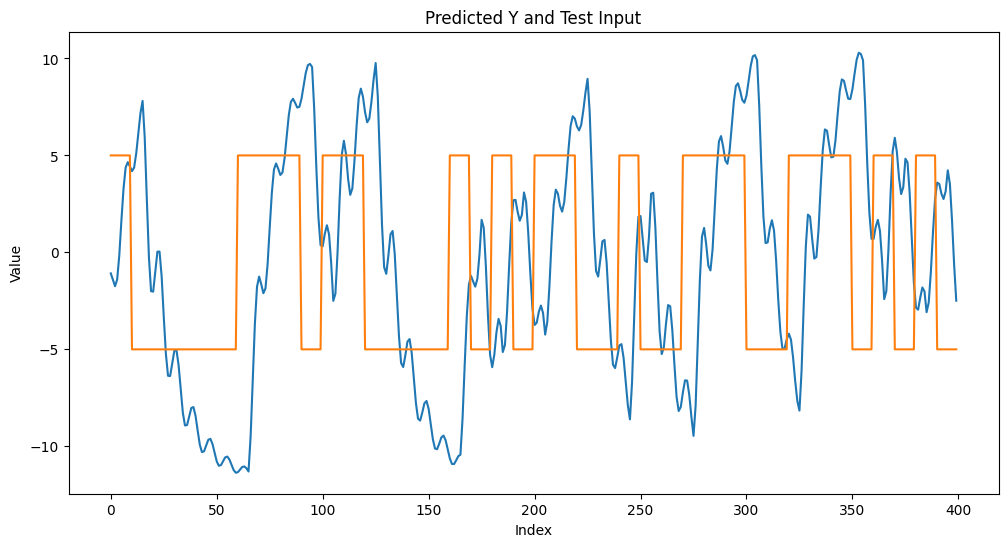

In [41]:
if best_model is not None:
    n = best_matrix['n']
    m = best_matrix['m']
    d = best_matrix['d']

    # Make sure we are using the right indexes by constructing the matrix again
    X_arx_full, y_arx_full = BuildArxMatrix(y_train, u_train, n, m, d)

    # Concatenate the new inputs
    u = np.concatenate((u_train, u_test))
    
    # Prediction on test data
    y_pred_full, y_pred = IterativePrediction(y_arx_full, u[max(n, d + m):], mu, sigma, n, m, d, best_model)
    last_400_y_pred = y_pred[-400:]
    
    print(f"Length of y_pred: {len(y_pred)}")
    print(f"Length of last_400_y_pred: {len(last_400_y_pred)}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(last_400_y_pred, label="Predicted Y", linestyle='-')
    plt.plot(u[-400:], label="Test Input", linestyle='-')
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Predicted Y and Test Input")

    np.save("./data/y_pred.npy", last_400_y_pred)
else:
    print("No stable model was selected.")